# Introduction

In this notebook, I went through all my code from before and write them into functions. In this way, when I continue to test out my hypothesis, it is easier to call functions for all 10 classes. In addition, not only did I test out the class of 2, but I also did the same preprocessing, generating adversarial attacks, and creating a general perturbation pattern for the class of 8. I also created heatmaps for both classes to try to figure out if the perturbation came from the input images. 

** For better results, I switched from using the testing data to training data as the training data provide a larger number of images and thus gives a better general perturbation pattern. For example, the previous notebook which uses testing data only has 1032 images of 2. Now, images of 2 have 5958 indices which are larger than 1032 from the testing set.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [4]:
tf.__version__

'2.8.0'

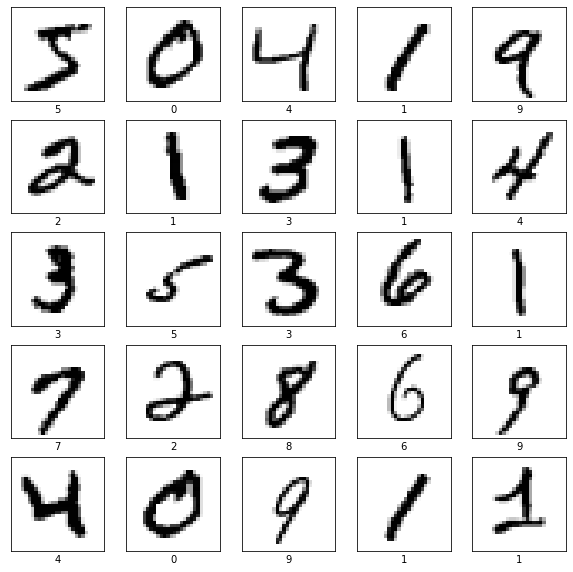

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)

In [7]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images / 255.
test_images = test_images / 255.

In [8]:
train_images.shape

(60000, 28, 28)

Text(0.5, 1.0, 'Ground Truth : 7')

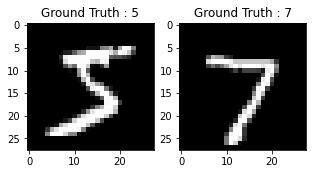

In [9]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))

In [10]:
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)
train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [11]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images / 255.
test_images = test_images / 255.

## One hot encoded vector

In [12]:
from tensorflow.keras.utils import to_categorical
# Change the labels from categorical to one-hot encoding
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_labels_one_hot[0])

Original label: 5
After conversion to one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [13]:
train_labels_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [14]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_label, valid_label = train_test_split(train_images, train_labels_one_hot, test_size=0.1, random_state=13)

In [15]:
train_X.shape

(54000, 28, 28, 1)

## CNN Model

In [16]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [17]:
batch_size = 64
epochs = 10
num_classes = 10

In [18]:
mnist_model = Sequential()
mnist_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
mnist_model.add(MaxPooling2D((2, 2),padding='same'))
mnist_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
mnist_model.add(Flatten())
mnist_model.add(Dense(128, activation='linear'))
mnist_model.add(Dense(num_classes, activation='softmax'))

2022-10-25 20:03:31.132197: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:

# mnist_model.compile(loss=keras.losses.SparseCategoricalCrossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])


mnist_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [20]:
mnist_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

In [21]:
mnist_train = mnist_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/10
844/844 [==============================] - 28s 33ms/step - loss: 0.4418 - accuracy: 0.8631 - val_loss: 0.1818 - val_accuracy: 0.9447
Epoch 2/10
844/844 [==============================] - 28s 33ms/step - loss: 0.1420 - accuracy: 0.9582 - val_loss: 0.1164 - val_accuracy: 0.9643
Epoch 3/10
844/844 [==============================] - 28s 33ms/step - loss: 0.0961 - accuracy: 0.9712 - val_loss: 0.0770 - val_accuracy: 0.9765
Epoch 4/10
844/844 [==============================] - 27s 33ms/step - loss: 0.0745 - accuracy: 0.9770 - val_loss: 0.0803 - val_accuracy: 0.9740
Epoch 5/10
844/844 [==============================] - 28s 33ms/step - loss: 0.0636 - accuracy: 0.9810 - val_loss: 0.0734 - val_accuracy: 0.9770
Epoch 6/10
844/844 [==============================] - 28s 33ms/step - loss: 0.0577 - accuracy: 0.9820 - val_loss: 0.0740 - val_accuracy: 0.9775
Epoch 7/10
844/844 [==============================] - 28s 33ms/step - loss: 0.0531 - accuracy: 0.9837 - val_loss: 0.0710 - val_accuracy:

In [22]:
test_eval = mnist_model.evaluate(test_images, test_labels_one_hot, verbose=0)

In [23]:
test_eval = mnist_model.evaluate(test_images, test_labels_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.049444038420915604
Test accuracy: 0.9840999841690063


In [24]:
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']
class_names[train_labels[20]]

'4'

# Get labels, images, perturbation of all class n

#### indices of class 2

In [25]:
def get_indicies_of_class_n(n_in_string):
    indices = [i for i in range(len(train_images)) if class_names[train_labels[i]] == n_in_string]
    print('Found', len(indices), 'twos')
    print(indices[:20])
    return indices

In [26]:
indices_of_1 = get_indicies_of_class_n('1')

Found 6742 twos
[3, 6, 8, 14, 23, 24, 40, 59, 67, 70, 72, 77, 78, 99, 102, 104, 105, 112, 113, 124]


In [27]:
indices_of_2 = get_indicies_of_class_n('2')

Found 5958 twos
[5, 16, 25, 28, 76, 82, 109, 117, 120, 122, 143, 159, 161, 171, 178, 180, 187, 189, 190, 199]


In [28]:
indices_of_3 = get_indicies_of_class_n('3')

Found 6131 twos
[7, 10, 12, 27, 30, 44, 49, 50, 74, 86, 98, 107, 111, 130, 135, 136, 149, 157, 179, 181]


In [29]:
indices_of_4 = get_indicies_of_class_n('4')

Found 5842 twos
[2, 9, 20, 26, 53, 58, 60, 61, 64, 89, 92, 115, 127, 131, 139, 142, 150, 163, 164, 166]


In [30]:
indices_of_5 = get_indicies_of_class_n('5')

Found 5421 twos
[0, 11, 35, 47, 65, 100, 132, 138, 145, 173, 175, 182, 191, 219, 236, 239, 244, 259, 266, 273]


In [31]:
indices_of_6 = get_indicies_of_class_n('6')

Found 5918 twos
[13, 18, 32, 36, 39, 62, 66, 73, 83, 90, 93, 106, 126, 129, 147, 151, 155, 165, 186, 204]


In [32]:
indices_of_7 = get_indicies_of_class_n('7')

Found 6265 twos
[15, 29, 38, 42, 52, 71, 79, 84, 91, 96, 101, 103, 123, 140, 141, 148, 158, 168, 185, 193]


In [33]:
indices_of_8 = get_indicies_of_class_n('8')

Found 5851 twos
[17, 31, 41, 46, 55, 85, 94, 97, 125, 137, 144, 146, 160, 188, 197, 202, 225, 240, 245, 265]


In [34]:
indices_of_9 = get_indicies_of_class_n('9')

Found 5949 twos
[4, 19, 22, 33, 43, 45, 48, 54, 57, 80, 87, 110, 116, 133, 153, 154, 162, 167, 170, 172]


In [35]:
indices_of_0 = get_indicies_of_class_n('0')

Found 5923 twos
[1, 21, 34, 37, 51, 56, 63, 68, 69, 75, 81, 88, 95, 108, 114, 118, 119, 121, 156, 169]


In [36]:
# plt.figure(figsize=(10,10))
# for i in range(20):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(test_images[indices_of_8[i]], cmap=plt.cm.binary)
#     plt.xlabel(class_names[test_labels[indices_of_8[i]]])
# plt.show()

#### images of class n

In [37]:
def get_images_of_class_n(test_images, indices):
    images = [train_images[i] for i in indices]
    print('length of images: ',len(images))
    for i in range(len(images)):
        images[i] = images[i].reshape(1, 28, 28, 1)
        images[i]= tf.convert_to_tensor(images[i], dtype=tf.float32)
    return images

In [38]:
images_of_1 = get_images_of_class_n(test_images, indices_of_1)

length of images:  6742


In [39]:
images_of_2 = get_images_of_class_n(test_images, indices_of_2)

length of images:  5958


In [40]:
images_of_3 = get_images_of_class_n(test_images, indices_of_3)

length of images:  6131


In [41]:
images_of_4 = get_images_of_class_n(test_images, indices_of_4)

length of images:  5842


In [42]:
images_of_5 = get_images_of_class_n(test_images, indices_of_5)

length of images:  5421


In [43]:
images_of_6 = get_images_of_class_n(test_images, indices_of_6)

length of images:  5918


In [44]:
images_of_7 = get_images_of_class_n(test_images, indices_of_7)

length of images:  6265


In [45]:
images_of_2[0].shape

TensorShape([1, 28, 28, 1])

In [46]:
images_of_8 = get_images_of_class_n(test_images, indices_of_8)

length of images:  5851


In [47]:
images_of_9 = get_images_of_class_n(test_images, indices_of_9)

length of images:  5949


In [48]:
images_of_0 = get_images_of_class_n(test_images, indices_of_0)

length of images:  5923


### Create Prediction of all class 2

In [49]:
def perdiction_of_class_n(images):
    prediction = [mnist_model.predict(images[i]) for i in range(len(images))]
#     print('label/argmax(): ', prediction.argmax())
#     print('np.max(): ', 100*np.max(prediction))
    return prediction


In [50]:
prediction_of_1 =perdiction_of_class_n(images_of_1)

In [51]:
prediction_of_2 =perdiction_of_class_n(images_of_2)

In [52]:
prediction_of_3 =perdiction_of_class_n(images_of_3)

In [53]:
prediction_of_4 =perdiction_of_class_n(images_of_4)

In [54]:
prediction_of_5 =perdiction_of_class_n(images_of_5)

In [55]:
prediction_of_6 =perdiction_of_class_n(images_of_6)

In [56]:
prediction_of_7 =perdiction_of_class_n(images_of_7)

In [57]:
prediction_of_8 =perdiction_of_class_n(images_of_8)

In [58]:
prediction_of_9 =perdiction_of_class_n(images_of_9)

In [59]:
prediction_of_0 =perdiction_of_class_n(images_of_0)

In [60]:
# prediction_of_2[1031]

In [61]:
# (prediction_of_2[1031]).argmax()

In [62]:
# 100*np.max(prediction_of_2[1031])

In [63]:
def create_labels(prediction, images):
    labels = [tf.one_hot(1, prediction[i].shape[-1]) for i in range(len(images))]
    labels = [tf.reshape(labels[i], (1, prediction[i].shape[-1])) for i in range(len(images))]
# prediction_of_2
    return labels
# label_of_2 = create_labels(prediction_of_2, images_of_2)

In [64]:
label_of_1 = create_labels(prediction_of_1, images_of_1)

In [65]:
label_of_2 = create_labels(prediction_of_2, images_of_2)

In [66]:
label_of_3 = create_labels(prediction_of_3, images_of_3)

In [67]:
label_of_4 = create_labels(prediction_of_4, images_of_4)

In [68]:
label_of_5 = create_labels(prediction_of_5, images_of_5)

In [69]:
label_of_6 = create_labels(prediction_of_6, images_of_6)

In [70]:
label_of_7 = create_labels(prediction_of_7, images_of_7)

In [71]:
label_of_8 = create_labels(prediction_of_8, images_of_8)

In [72]:
label_of_9 = create_labels(prediction_of_9, images_of_9)

In [73]:
label_of_0 = create_labels(prediction_of_0, images_of_0)

# creating adversarial example with [2]

In [74]:
# create adversarial pattern with Cross Entropy loss func and the gradient
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, model):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
#         print(loss)

  # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad


In [75]:
# create_labels(prediction_of_2, images_of_2)

In [76]:
def create_perturb_of_class_n(images, labels):
    perturb = [create_adversarial_pattern(images[i], labels[i], mnist_model) 
                      for i in range(len(images))]
    return perturb

In [77]:
perturbations_of_1 = create_perturb_of_class_n(images_of_1, label_of_1)

In [78]:
perturbations_of_2 = create_perturb_of_class_n(images_of_2, label_of_2)

In [79]:
perturbations_of_3 = create_perturb_of_class_n(images_of_3, label_of_3)

In [80]:
perturbations_of_4 = create_perturb_of_class_n(images_of_4, label_of_4)

In [81]:
perturbations_of_5 = create_perturb_of_class_n(images_of_5, label_of_5)

In [82]:
perturbations_of_6 = create_perturb_of_class_n(images_of_6, label_of_6)

In [83]:
perturbations_of_7 = create_perturb_of_class_n(images_of_7, label_of_7)

In [84]:
perturbations_of_8 = create_perturb_of_class_n(images_of_8, label_of_8)

In [85]:
perturbations_of_9 = create_perturb_of_class_n(images_of_9, label_of_9)

In [86]:
perturbations_of_0 = create_perturb_of_class_n(images_of_0, label_of_0)

## Change perturbation shape to 28,28

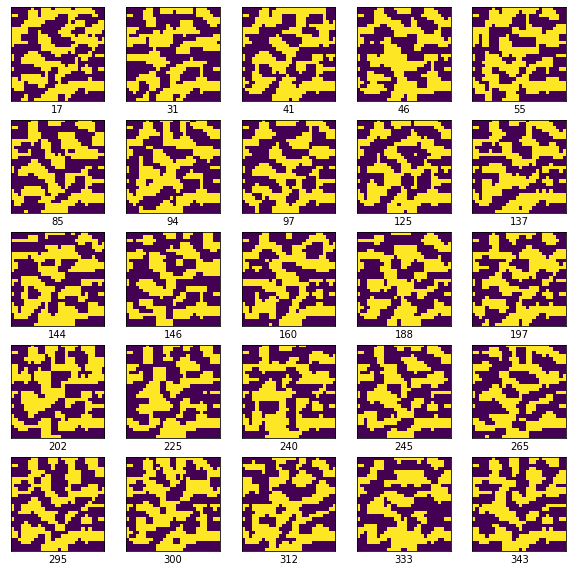

In [87]:
# 25 perturbations of class 2
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(perturbations_of_8[i][0] * 0.05 + 0.05)
    plt.xlabel(indices_of_8[i])
plt.show()

## kmeans

In [88]:
def k_means_perturb(perturbations):
    k_mean_perturb = [perturbations[i][0].numpy() for i in range(len(perturbations))]
    k_mean_perturb = np.squeeze(k_mean_perturb)
    k_mean_perturb= k_mean_perturb.reshape(len(perturbations),-1)
    print("shape: ", k_mean_perturb.shape)
    return k_mean_perturb
    

In [89]:
perturbations_kmeans_1 = k_means_perturb(perturbations_of_1)

shape:  (6742, 784)


In [90]:
perturbations_kmeans_2 = k_means_perturb(perturbations_of_2)

shape:  (5958, 784)


In [91]:
perturbations_kmeans_3 = k_means_perturb(perturbations_of_3)

shape:  (6131, 784)


In [92]:
perturbations_kmeans_4 = k_means_perturb(perturbations_of_4)

shape:  (5842, 784)


In [93]:
perturbations_kmeans_5 = k_means_perturb(perturbations_of_5)

shape:  (5421, 784)


In [94]:
perturbations_kmeans_6 = k_means_perturb(perturbations_of_6)

shape:  (5918, 784)


In [95]:
perturbations_kmeans_7 = k_means_perturb(perturbations_of_7)

shape:  (6265, 784)


In [96]:
perturbations_kmeans_8 = k_means_perturb(perturbations_of_8)

shape:  (5851, 784)


In [97]:
perturbations_kmeans_9 = k_means_perturb(perturbations_of_9)

shape:  (5949, 784)


In [98]:
perturbations_kmeans_0 = k_means_perturb(perturbations_of_0)

shape:  (5923, 784)


In [99]:
import random
def get_random_images_of_class_n(n_in_string):
    indices = [i for i in range(len(train_images)) if class_names[train_labels[i]] == n_in_string]
    print('Found', len(indices), 'twos')
    print(indices[:20])
#     return indices
    random_num = random.choice(indices)
    result = train_images[random_num].reshape(len(train_images[random_num]),-1)
    return result
    

Found 5958 twos
[5, 16, 25, 28, 76, 82, 109, 117, 120, 122, 143, 159, 161, 171, 178, 180, 187, 189, 190, 199]


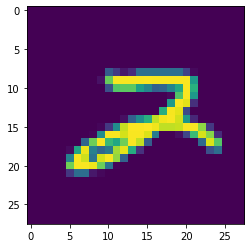

In [100]:
plt.imshow(get_random_images_of_class_n('2'))

## k mean cluster of 1

In [102]:
result = train_images[180].reshape(len(train_images[0]),-1)
result.shape

(28, 28)

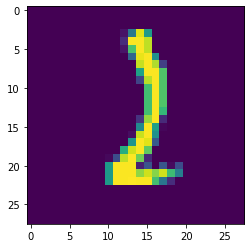

In [103]:
plt.imshow(result)

In [104]:
# k mean cluster of 1
from sklearn.cluster import KMeans
def kmean_of_class_n(perturbation):
    kmean_mnist_1 = KMeans(n_clusters = 1)
    kmean_mnist_1.fit(perturbation)
    #extract the centroids and labels for each pixel
    centroids_1 = kmean_mnist_1.cluster_centers_
    labels_1 = kmean_mnist_1.labels_
    centroids_1 = centroids_1.reshape(1,28,28)

    for i in centroids_1:
        plt.figure()
        plt.imshow(i)
    #     plt.axis('off')
        result = i
        print(i.shape)
        plt.show()
    return result, labels_1

(28, 28)


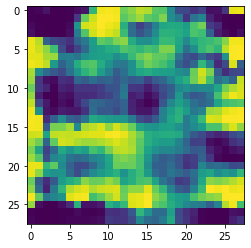

True

In [105]:
import cv2
class_2_kmean, labels_2 = kmean_of_class_n(perturbations_kmeans_2)
# class_2_kmean= class_2_kmean.save("class_2_kmean.jpg")
cv2.imwrite('2.jpg',class_2_kmean)

In [106]:
class_2_kmean.shape

(28, 28)

(28, 28)


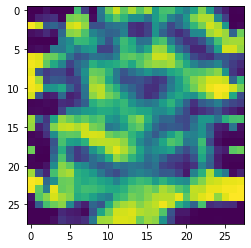

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'img'


In [107]:
class_8_kmean = kmean_of_class_n(perturbations_kmeans_8)
cv2.imwrite('8.jpg',class_8_kmean)

## plotting images

## 2

In [108]:
from PIL import Image, ImageChops
  
# assign images
# img1 = Image.open('/Users/Vivian/desktop/2.jpg')
# img2 = Image.open("/Users/Vivian/desktop/8.jpg")


# img1 = cv2.imread('/Users/Vivian/desktop/2.png')
import cv2
img2 = cv2.imread('/Users/Vivian/desktop/2.jpg')
image2 = cv2.imread("2.jpg", 0)
# img1 = cv2.imread('/Users/Vivian/desktop/2.png')
# img1 = cv2.imread('2.jpg')

In [109]:
img2.shape

(806, 800, 3)

In [110]:
image2.shape

(28, 28)

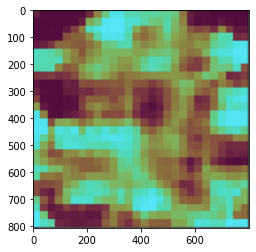

In [111]:
import matplotlib.pyplot as plt
plt.imshow(img2)

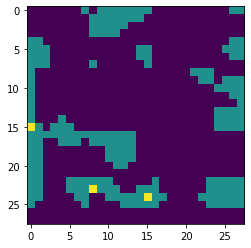

In [112]:
plt.imshow(image2)

In [113]:
# import cv2
# lab = cv2.cvtColor(img2, cv2.COLOR_BGR2LAB)
# a_component = lab[:,:,1]
# th = cv2.threshold(a_component,140,255,cv2.THRESH_BINARY)[1]
# blur = cv2.GaussianBlur(th,(13,13), 11)
# heatmap_img_2 = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
# cv2.imshow('image', img2)
# cv2.imshow('heatmap', heatmap_img_2)
# cv2.waitKey()
# # cv2.destroyAllWindows()
# # cv2.waitKey(1)

In [114]:
# import cv2
# lab = cv2.cvtColor(image1, cv2.COLOR_BGR2LAB)
# a_component = lab[:,:,1]
# th = cv2.threshold(a_component,140,255,cv2.THRESH_BINARY)[1]
# blur = cv2.GaussianBlur(th,(13,13), 11)
# heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
# cv2.imshow('image', image1)
# cv2.imshow('heatmap', heatmap_img)
# cv2.waitKey()
# # cv2.destroyAllWindows()
# # cv2.waitKey(1)

### result after running it

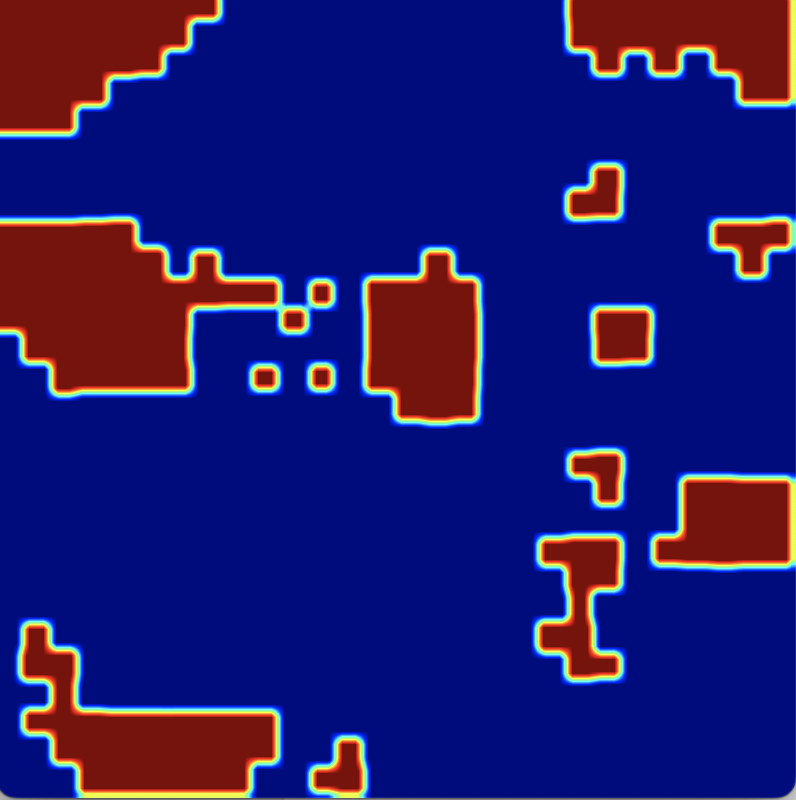

## 8

In [115]:
from PIL import Image, ImageChops
  
# assign images
# img1 = Image.open('/Users/Vivian/desktop/2.jpg')
# img2 = Image.open("/Users/Vivian/desktop/8.jpg")


# img1 = cv2.imread('/Users/Vivian/desktop/2.png')
import cv2
img8 = cv2.imread('/Users/Vivian/desktop/8.jpg')
image8 = cv2.imread("8.jpg", 0)
# img1 = cv2.imread('/Users/Vivian/desktop/2.png')
# img1 = cv2.imread('2.jpg')

In [116]:
img8.shape

(756, 760, 3)

In [117]:
image8.shape

(28, 28)

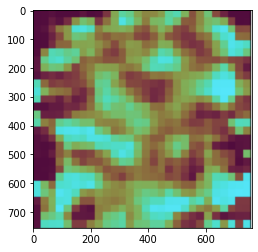

In [118]:
import matplotlib.pyplot as plt
plt.imshow(img8)

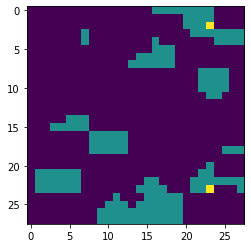

In [119]:
plt.imshow(image8)

In [120]:
# import cv2
# lab = cv2.cvtColor(img8, cv2.COLOR_BGR2LAB)
# a_component = lab[:,:,1]
# th = cv2.threshold(a_component,140,255,cv2.THRESH_BINARY)[1]
# blur = cv2.GaussianBlur(th,(13,13), 11)
# heatmap_img_8 = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
# cv2.imshow('image', img8)
# cv2.imshow('heatmap', heatmap_img_8)
# cv2.waitKey()
# # cv2.destroyAllWindows()
# # cv2.waitKey(1)

In [121]:
# import cv2
# lab = cv2.cvtColor(image8, cv2.COLOR_BGR2LAB)
# a_component = lab[:,:,1]
# th = cv2.threshold(a_component,140,255,cv2.THRESH_BINARY)[1]
# blur = cv2.GaussianBlur(th,(13,13), 11)
# heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
# cv2.imshow('image', image8)
# cv2.imshow('heatmap', heatmap_img)
# cv2.waitKey()
# # cv2.destroyAllWindows()
# # cv2.waitKey(1)

### result after running it

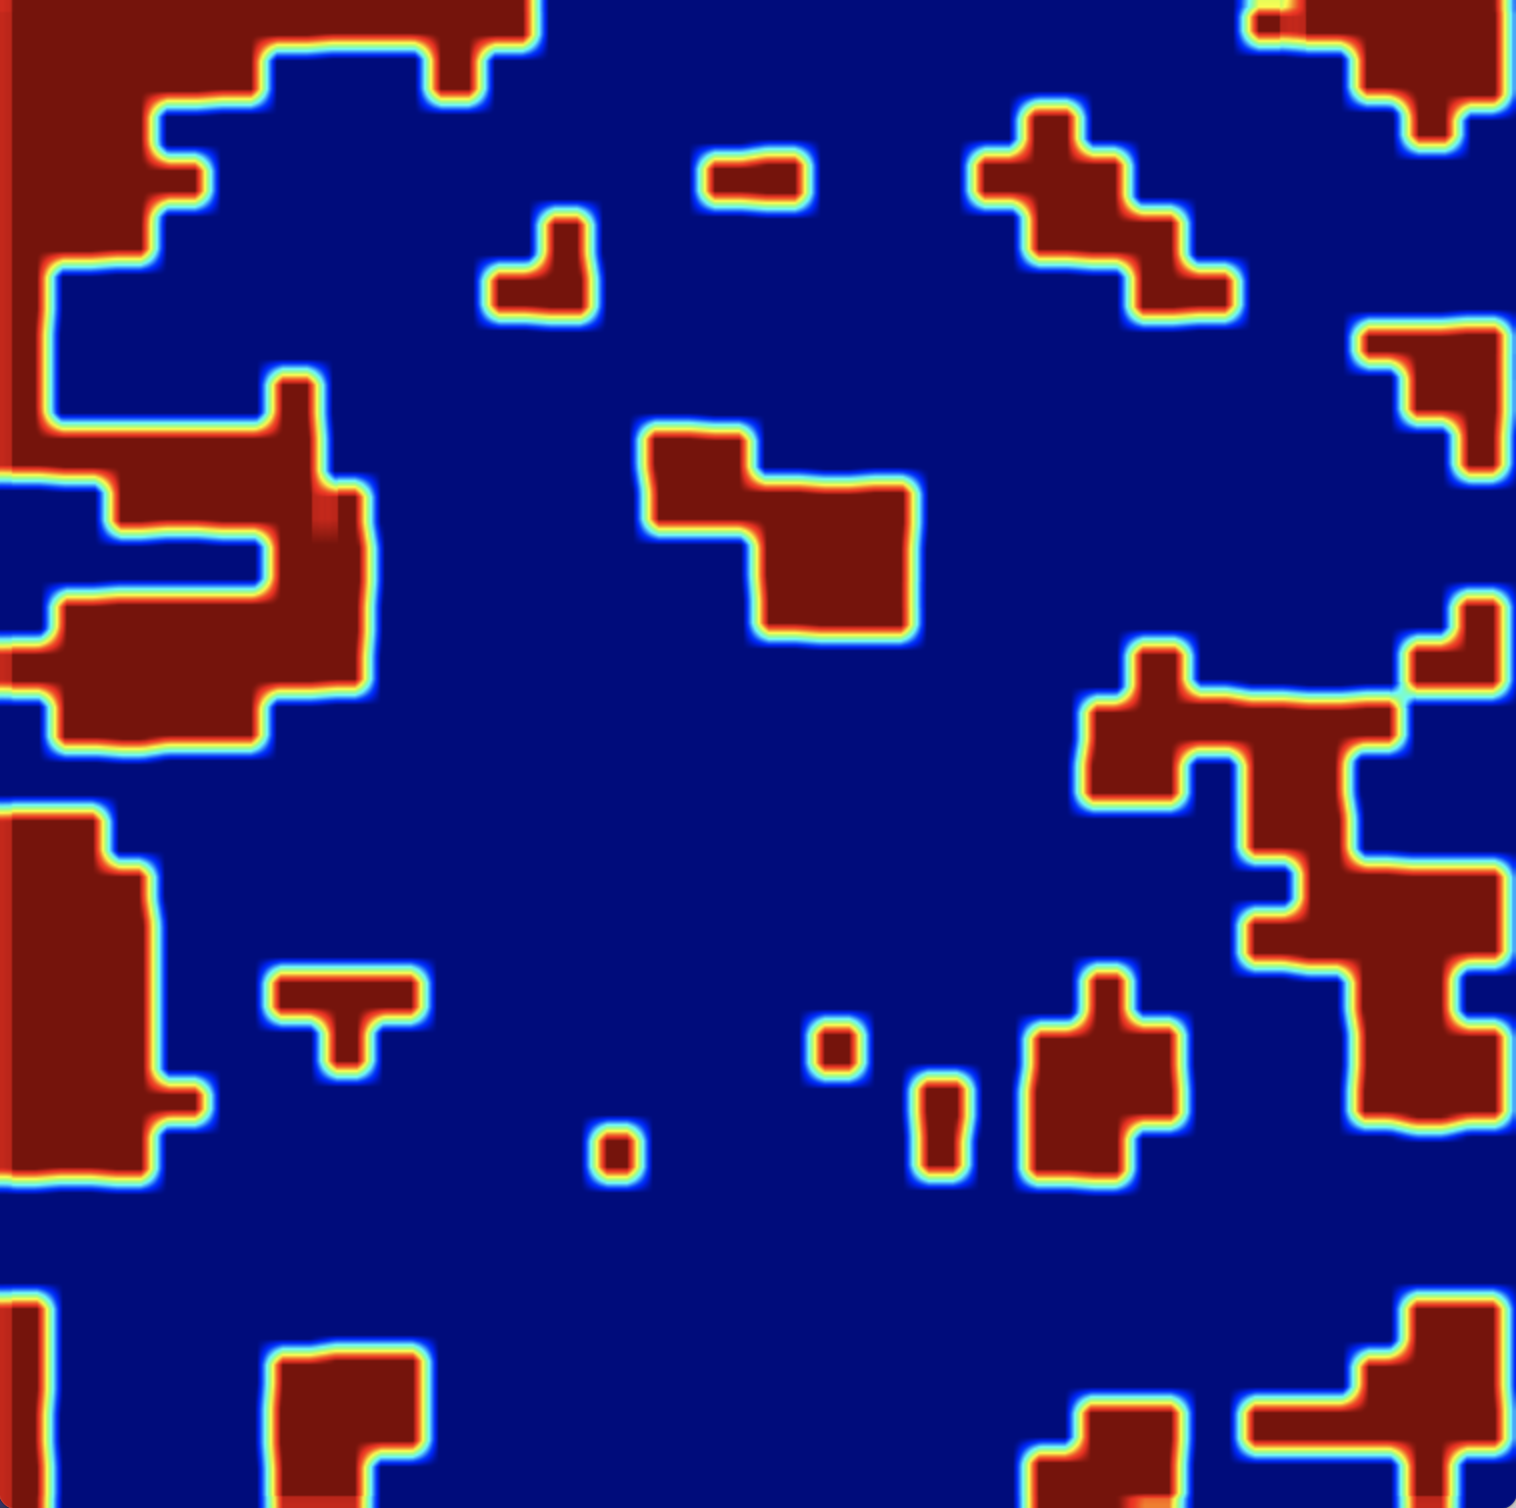

## Produce K mean for training set(original) images of 2

training images_of_2_testingset shape (60000, 28, 28)
len indicies 5958
length of images:  5958
shape of images:  (5958, 28, 28)


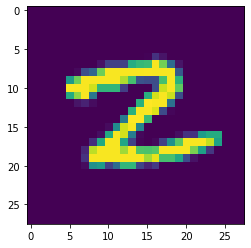

In [122]:
def get_images_of_class_n_testing(train_images, indices):
    train_images = train_images.reshape(60000,28,28)
#     train_images = train_images.reshape(len(train_images), -1)
    print('training images_of_2_testingset shape', train_images.shape)
    print('len indicies', len(indices))
    images = np.empty(shape=(len(indices),28,28))
    count = 0
    for i in indices:
        images[count] = train_images[i]
        count+=1
    print('length of images: ',len(images))
    print('shape of images: ',images.shape)
#     print('testing of images: ',images[0])
    return images
images_of_2_testing = get_images_of_class_n_testing(train_images, indices_of_2)
images_of_2_testing
plt.imshow(images_of_2_testing[10])

In [123]:
images_of_2_testing= images_of_2_testing.reshape(len(images_of_2_testing), -1)
images_of_2_testing.shape

(5958, 784)

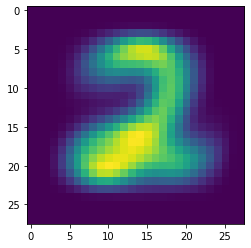

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits


kmean_mnist = KMeans(n_clusters = 1)
kmean_mnist.fit(images_of_2_testing)
#extract the centroids and labels for each pixel
centroids = kmean_mnist.cluster_centers_
labels = kmean_mnist.labels_
centroids = centroids.reshape(1,28,28)

for i in centroids:
    plt.figure()
    plt.imshow(i)
#     plt.axis('off')
    plt.show()

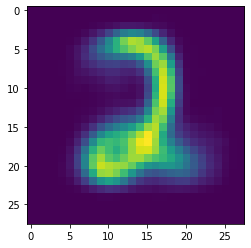

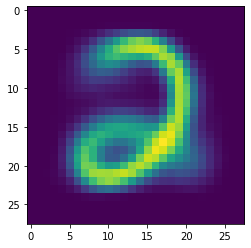

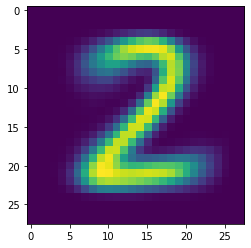

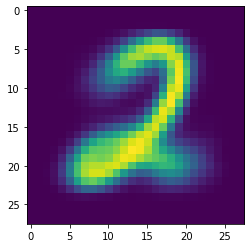

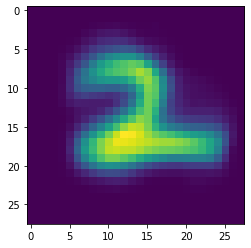

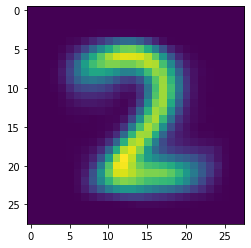

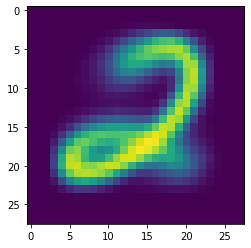

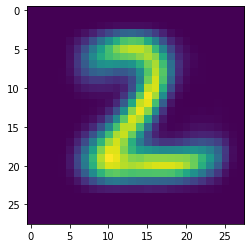

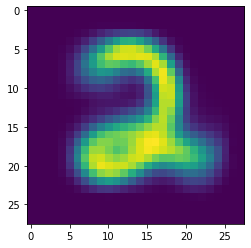

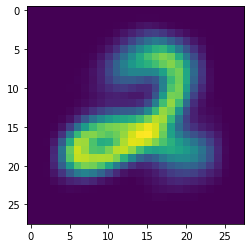

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits


kmean_mnist = KMeans(n_clusters = 10)
kmean_mnist.fit(images_of_2_testing)
#extract the centroids and labels for each pixel
centroids = kmean_mnist.cluster_centers_
labels = kmean_mnist.labels_
centroids = centroids.reshape(10,28,28)

for i in centroids:
    plt.figure()
    plt.imshow(i)
#     plt.axis('off')
    plt.show()

## Produce K mean for training set(origional) images of 8

In [126]:
## Produce K mean for training set images of 2

training images_of_2_testingset shape (60000, 28, 28)
len indicies 5851
length of images:  5851
shape of images:  (5851, 28, 28)


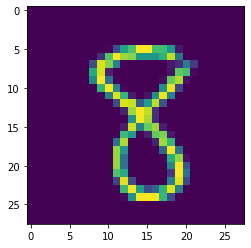

In [127]:
def get_images_of_class_n_testing(train_images, indices):
    train_images = train_images.reshape(60000,28,28)
#     train_images = train_images.reshape(len(train_images), -1)
    print('training images_of_2_testingset shape', train_images.shape)
    print('len indicies', len(indices))
    images = np.empty(shape=(len(indices),28,28))
    count = 0
    for i in indices:
        images[count] = train_images[i]
        count+=1
    print('length of images: ',len(images))
    print('shape of images: ',images.shape)
#     print('testing of images: ',images[0])
    return images
images_of_8_origin = get_images_of_class_n_testing(train_images, indices_of_8)
images_of_8_origin
plt.imshow(images_of_8_origin[10])

In [128]:
images_of_8_origin= images_of_8_origin.reshape(len(images_of_8_origin), -1)
images_of_8_origin.shape

(5851, 784)

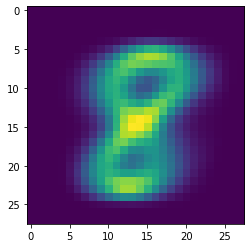

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits


kmean_mnist = KMeans(n_clusters = 1)
kmean_mnist.fit(images_of_8_origin)
#extract the centroids and labels for each pixel
centroids = kmean_mnist.cluster_centers_
labels = kmean_mnist.labels_
centroids = centroids.reshape(1,28,28)

for i in centroids:
    plt.figure()
    plt.imshow(i)
#     plt.axis('off')
    plt.show()

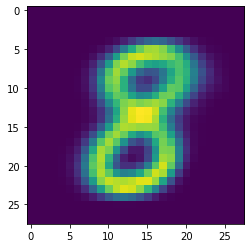

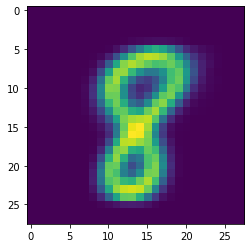

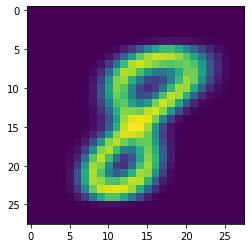

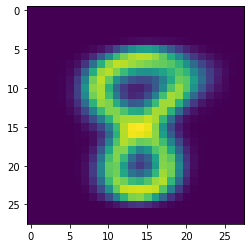

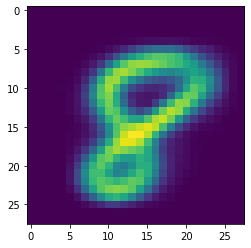

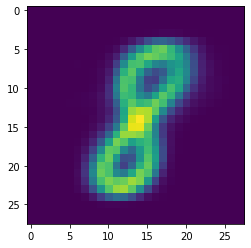

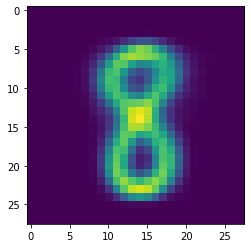

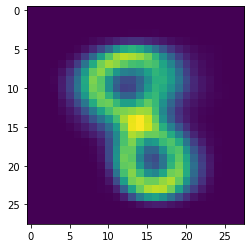

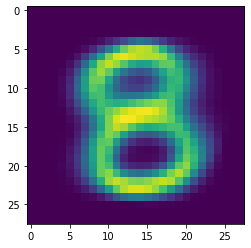

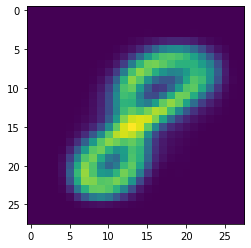

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits


kmean_mnist = KMeans(n_clusters = 10)
kmean_mnist.fit(images_of_8_origin)
#extract the centroids and labels for each pixel
centroids = kmean_mnist.cluster_centers_
labels = kmean_mnist.labels_
centroids = centroids.reshape(10,28,28)

for i in centroids:
    plt.figure()
    plt.imshow(i)
#     plt.axis('off')
    plt.show()

# Summary

Class of 2

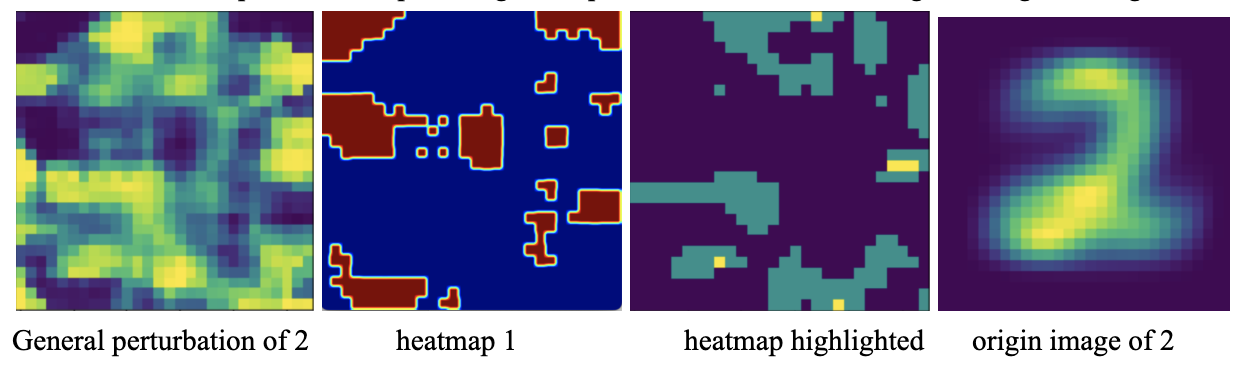

Class of 8

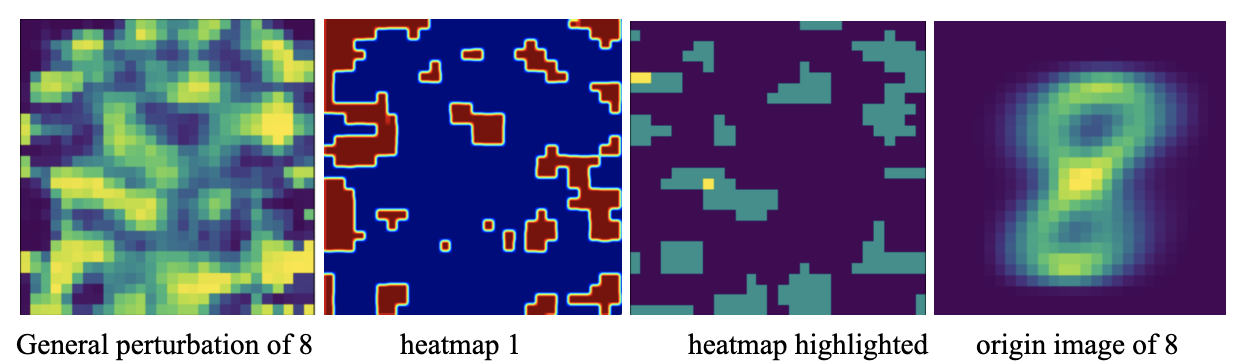

Plotted the difference between class of 2 results

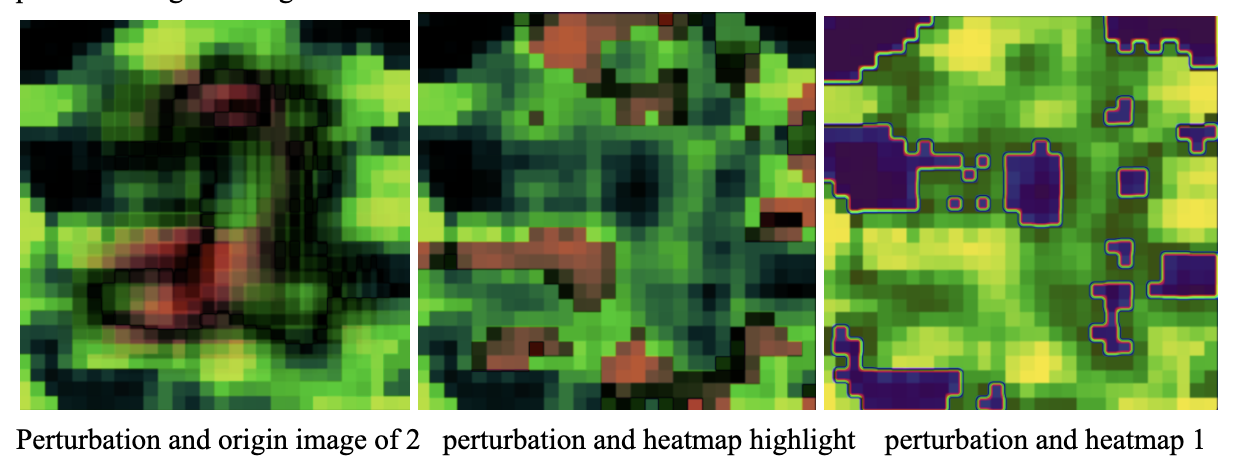

Plotted the difference between class of 8 results

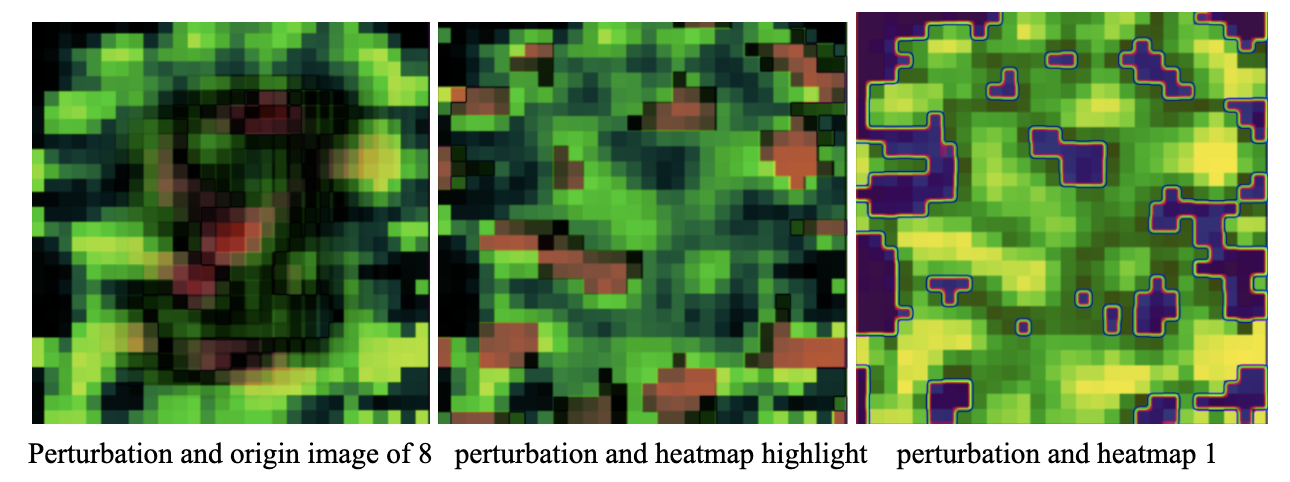